In [ ]:
#Import delle librerie
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.io import arff
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import clone

In [59]:
# ==========================================
# 1. CARICAMENTO DATASET LOCALE
# ==========================================
filename = 'seismic-bumps.arff'

if not os.path.exists(filename):
    print(f"ERRORE: Il file '{filename}' non è stato trovato nella cartella corrente.")
    print("Controlla di averlo caricato nello stesso percorso di questo notebook.")
else:
    print(f"Caricamento del file locale '{filename}'...")
    
    # Caricamento diretto da file
    data, meta = arff.loadarff(filename)
    df_raw = pd.DataFrame(data)

    # ==========================================
    # 2. PREPROCESSING E PULIZIA
    # ==========================================
    
    # A. Decodifica delle stringhe (da bytes b'...' a stringhe normali)
    # I file ARFF caricano il testo come bytes. Dobbiamo convertirli.
    str_cols = df_raw.select_dtypes([object]).columns
    df_raw[str_cols] = df_raw[str_cols].apply(lambda x: x.str.decode('utf-8'))
    
    # B. Preparazione Target e Feature
    # La colonna target in questo dataset si chiama 'class'
    target_col = 'class'
    
    # Convertiamo il target in interi (0 e 1) per sicurezza
    y = df_raw[target_col].astype(int)
    X = df_raw.drop(target_col, axis=1)

    # C. One-Hot Encoding per le feature categoriche
    # Seismic Bumps contiene lettere (a, b, W, N...). 
    # Le convertiamo in numeri (dummy variables) affinché i grafici sotto funzionino.
    X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

    # D. Creazione del DataFrame finale 'df'
    # Riuniamo tutto. Questo 'df' è quello che verrà usato dal tuo codice successivo.
    df_seismic = pd.concat([X_encoded, y], axis=1)

    print(f"Dataset caricato e processato correttamente.")
    print(f"Dimensioni finali: {df_seismic.shape}")
    print(f"Colonne (prime 5): {list(df_seismic.columns[:5])} ...")
    
    # Impostiamo lo stile grafico
    sns.set_theme(style="darkgrid")

Caricamento del file locale 'seismic-bumps.arff'...
Dataset caricato e processato correttamente.
Dimensioni finali: (2584, 21)
Colonne (prime 5): ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'nbumps'] ...


In [60]:
df_seismic.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,...,nbumps89,energy,maxenergy,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c,class
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2000.0,2000.0,0,0,0,0,0,0,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3000.0,3000.0,0,0,0,0,0,0,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Grafico a torta per capire come sono distribuite le classi

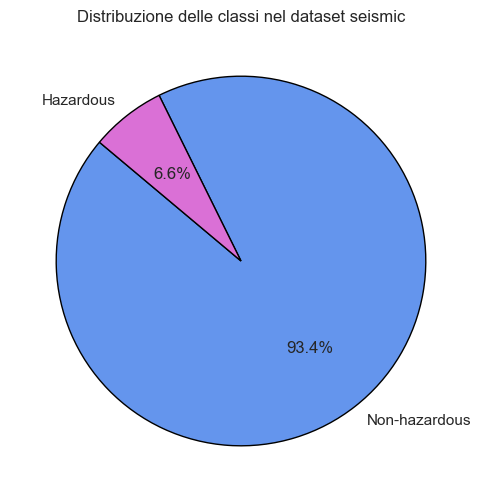

In [61]:
# Calcolo dei conteggi
class_counts = df_seismic['class'].value_counts()

# Creazione di un dizionario per mappare 0 e 1 ai nomi desiderati
mappa_nomi = {0: 'Non-hazardous', 1: 'Hazardous'}

# Applicazione della mappa all'indice per ottenere le nuove etichette
labels = class_counts.index.map(mappa_nomi)

sizes = class_counts.values

plt.figure(figsize=(6, 6))

# Nota: ho aggiunto 'colors' per rendere il grafico più leggibile (opzionale)
plt.pie(sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140,
        wedgeprops={'edgecolor': 'black'},
        colors=['cornflowerblue', 'orchid']) # Verde per non pericoloso, rosso per pericoloso

plt.title('Distribuzione delle classi nel dataset seismic')
plt.show()

# Distribuzione delle feature differenziate per classi

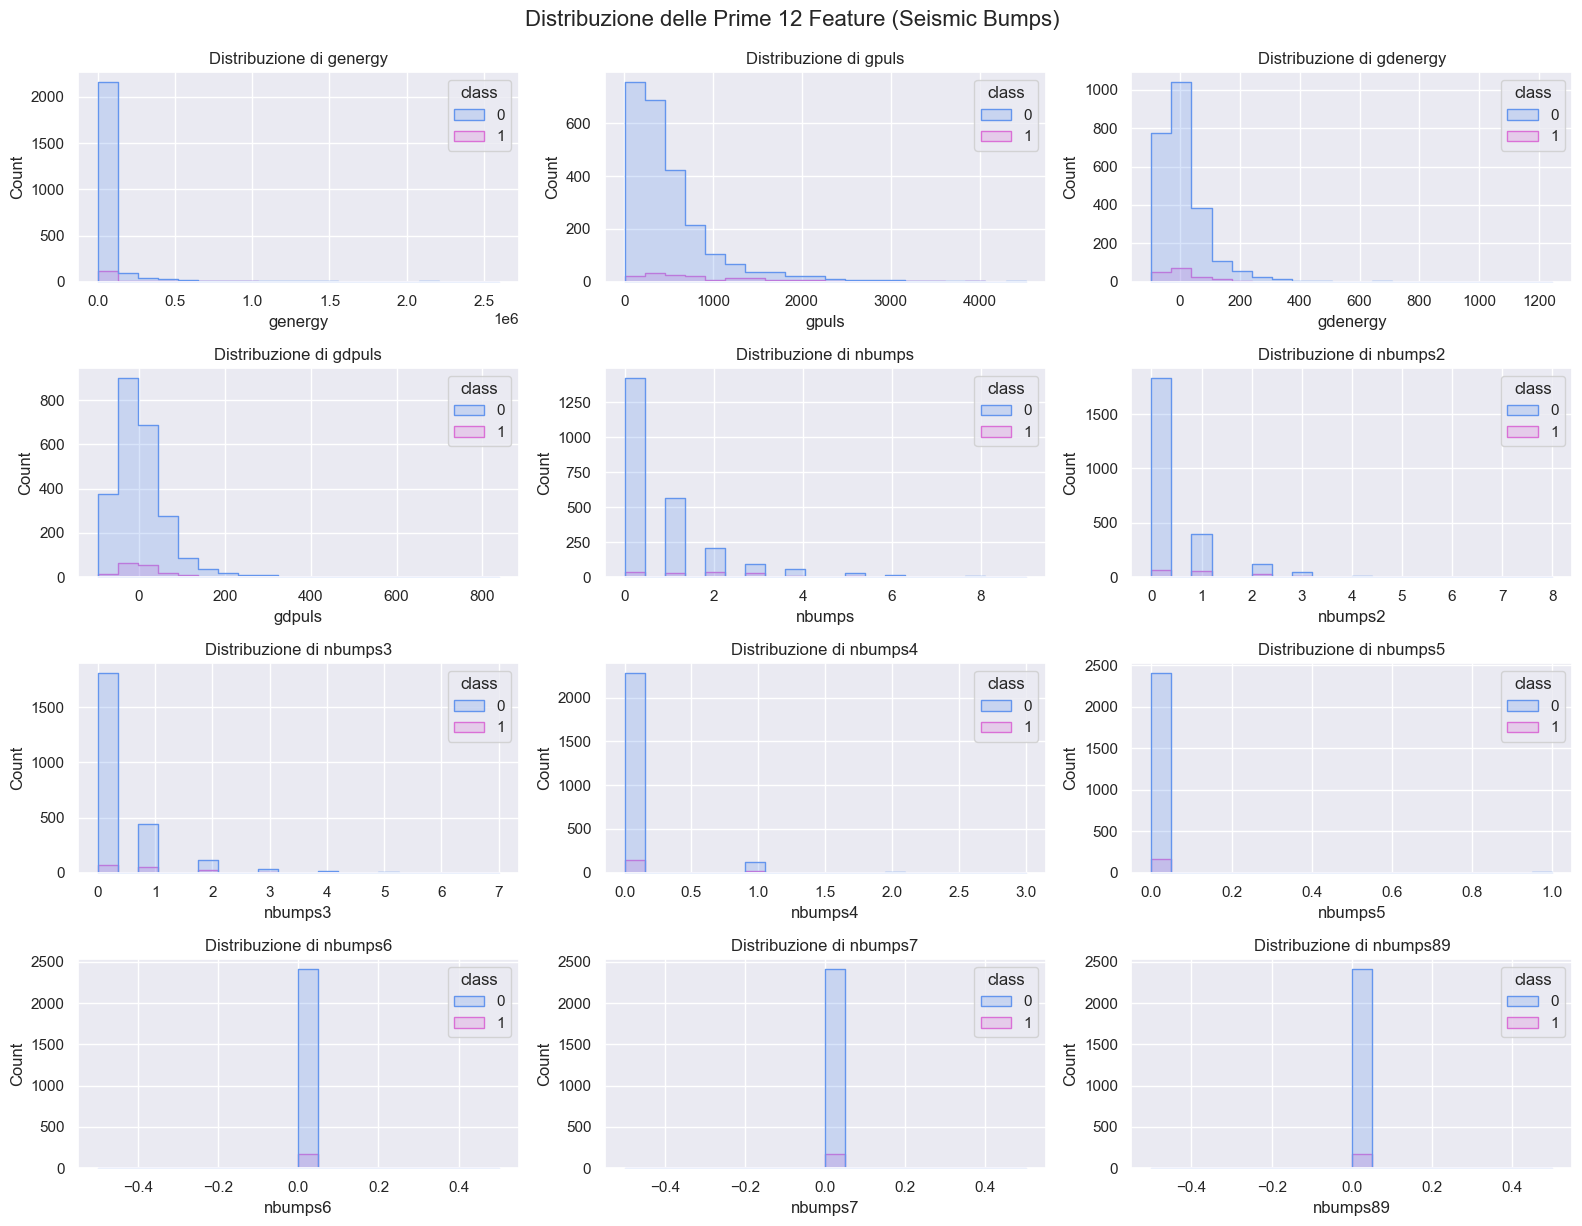

In [62]:
# 1. Mappa Colori per le Classi (0 = Safe, 1 = Hazardous)
color_map_dict = {0: 'cornflowerblue', 1: 'orchid'}

# 2. Recupero nomi feature (tutte tranne 'class')
feature_column_names = df_seismic.drop('class', axis=1).columns

# Selezioniamo le prime 12 feature
features_to_plot = feature_column_names[:12]

# 3. Creazione Grafico
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    
    sns.histplot(
        data=df_seismic,            # Usiamo il df creato prima
        x=feature,
        hue='class',        # Colonna target (0 o 1)
        kde=False,           # Linea di densità
        palette=color_map_dict,
        element='step',
        bins=20             # Ottimizza la visualizzazione
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Prime 12 Feature (Seismic Bumps)', y=1.02, fontsize=16)
plt.show()

### Matrice di correlazione tra le feature

Text(0.5, 1.0, "Matrice di Correlazione delle Feature dell'seismic Dataset")

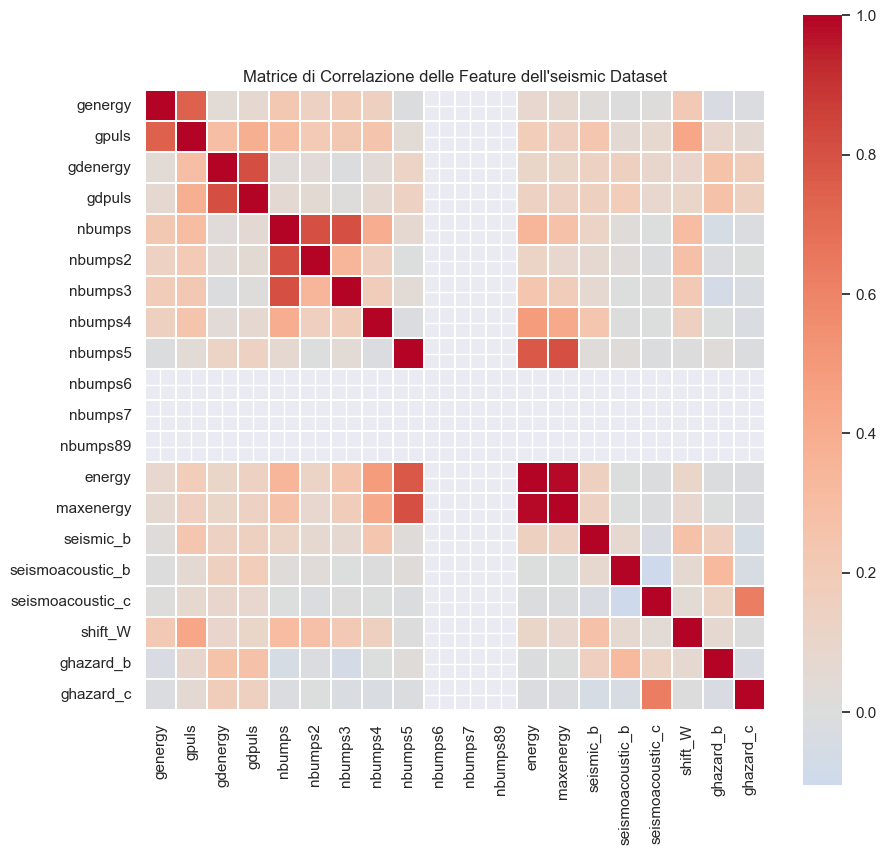

In [63]:
# Matrice di correlazione
plt.figure(figsize=(10, 10))
correlation_matrix = df_seismic.iloc[:, :-1].corr(method='pearson')  # Escludi la colonna delle etichette di classe
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, center=0, linewidths=0.3)
plt.title('Matrice di Correlazione delle Feature dell\'seismic Dataset')

### Box plot delle feature

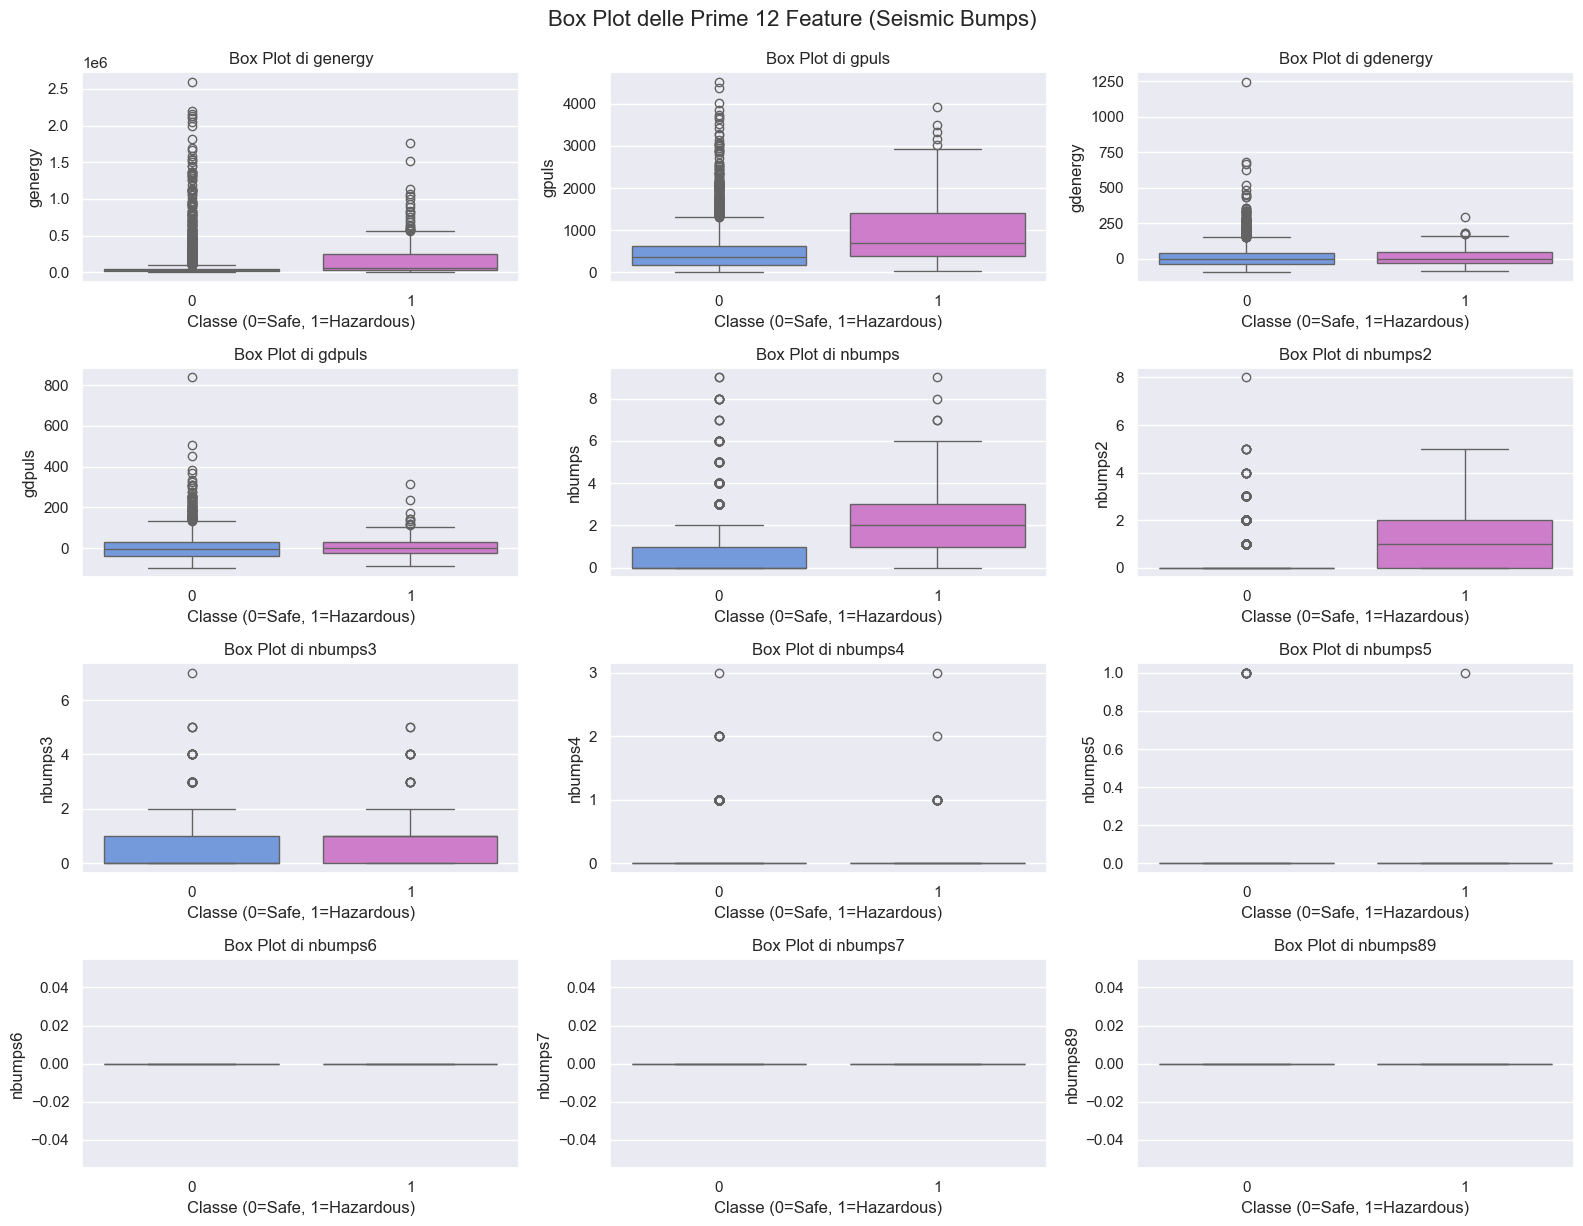

In [64]:
# 1. Configurazione Colori e Feature
# 0 = Safe (Blu), 1 = Hazardous (Orchid)
palette = {0: 'cornflowerblue', 1: 'orchid'}

# Prendiamo le prime 12 colonne (escludendo la classe)
features_to_plot = df_seismic.drop('class', axis=1).columns[:12]

# 2. Generazione Box Plot
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    
    sns.boxplot(
        data=df_seismic,
        x='class',
        y=feature,
        hue='class',      # Necessario per usare la palette
        palette=palette,
        legend=False      # Nascondiamo la legenda interna (ridondante)
    )
    plt.title(f'Box Plot di {feature}')
    plt.xlabel('Classe (0=Safe, 1=Hazardous)')

plt.tight_layout()
plt.suptitle('Box Plot delle Prime 12 Feature (Seismic Bumps)', y=1.02, fontsize=16)
plt.show()

### Parallel coordinates plot

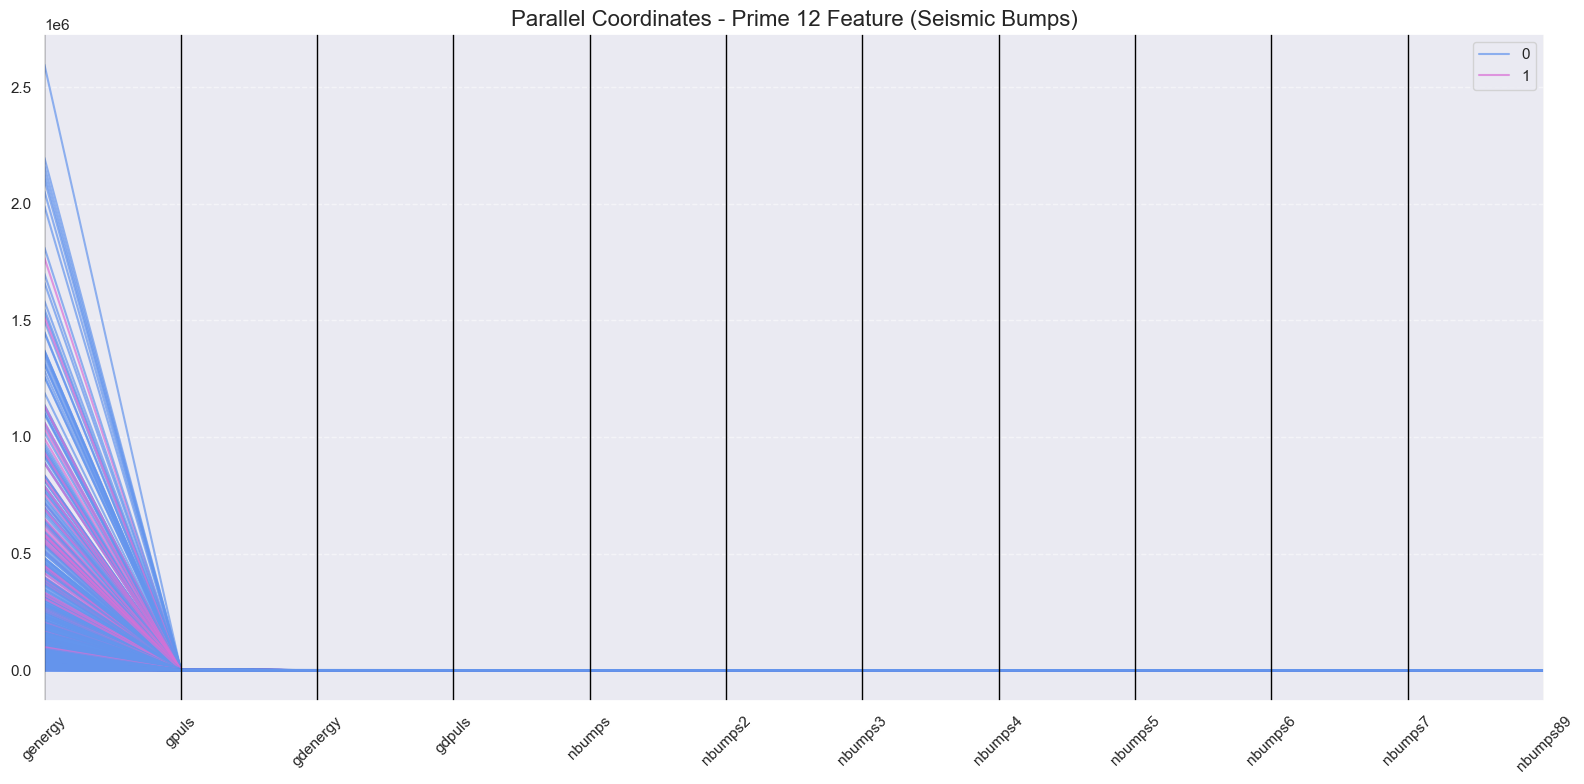

In [65]:
# 1. Selezione Feature
# Selezioniamo le prime 12 colonne (escludendo la classe)
# Nota: Il dataset originale ha scale diverse (es. energia vs numero di bump).
# Le coordinate parallele funzionano meglio se i dati sono normalizzati, 
# ma qui li plottiamo "grezzi" per vedere i range originali.
cols = df_seismic.drop('class', axis=1).columns[:12]

# 2. Configurazione Plot
plt.figure(figsize=(16, 8))

# 3. Generazione Grafico
# Pandas assegna i colori in ordine alle classi trovate (0 e 1).
# 0 (Safe) -> cornflowerblue
# 1 (Hazardous) -> orchid
parallel_coordinates(
    df_seismic[list(cols) + ['class']], 
    'class', 
    color=['cornflowerblue', 'orchid'], 
    alpha=0.7
)

plt.title('Parallel Coordinates - Prime 12 Feature (Seismic Bumps)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Siccome le feature hanno range molto diversi allora si scalano e si rifanno i grafici

In [71]:
## --- PREPROCESSING ---
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 20% per il test set

# 1. Separa X (features) e y (target) dal DataFrame originale
X = df_seismic.drop(target_col, axis=1)
y = df_seismic[target_col]

# 3. Divisione in Train/Test 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y 
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")



Dati di Addestramento (X_train): (2067, 20)
Target di Addestramento (y_train): (2067,)
Dati di Test (X_test): (517, 20)
Target di Test (y_test): (517,)


In [72]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inizio classificazione: Test Iperparametri di base

### SENZA CROSS-VALIDATION E STRATIFIEDKFOLD

In [ ]:
def evaluate_model(model, X_test, y_test, average='macro', TARGET_LABEL = 1,verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=TARGET_LABEL), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=TARGET_LABEL), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=TARGET_LABEL), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM (RBF)": SVC(
        random_state=RANDOM_STATE
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

In [ ]:
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 0

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- 3. CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    cv_scores = cross_val_score(model, X_train, y_train, cv=strat_cv, scoring='f1')
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train, y_train)
    
    metrics = evaluate_model(model, X_test, y_test, AVERAGE_TYPE, TARGET_LABEL ,False)
    
    metrics["Model"] = name
    results.append(metrics)
    
    cm = confusion_matrix(y_test, model.predict(X_test), labels=[0, 1])
    conf_matrices[name] = cm
    
    gen_error = cv_mean - metrics["F1"]
    print(f"   >> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
  
    if cv_mean < 0.6 and metrics["F1"] < 0.6:
        status = "underfitting"
    elif gen_error > 0.10:
        status = "overfitting"
    else:
        status = "good_generalization"
        
    print(f"   >> Model Status: {status}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
   >> Stratified CV F1: 0.1650 (+/- 0.0208)
   >> Generalization Error (CV F1 - Test F1): -0.7830
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: KNN
   >> Stratified CV F1: 0.0610 (+/- 0.0396)
   >> Generalization Error (CV F1 - Test F1): -0.9040
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: SVM (RBF)
   >> Stratified CV F1: 0.0000 (+/- 0.0000)
   >> Generalization Error (CV F1 - Test F1): -0.9660
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: MLP


C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\A

   >> Stratified CV F1: 0.0967 (+/- 0.0471)


C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


   >> Generalization Error (CV F1 - Test F1): -0.8693
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: Random Forest
   >> Stratified CV F1: 0.0133 (+/- 0.0267)
   >> Generalization Error (CV F1 - Test F1): -0.9537
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: AdaBoost
   >> Stratified CV F1: 0.0000 (+/- 0.0000)
   >> Generalization Error (CV F1 - Test F1): -0.9660
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: XGBoost
   >> Stratified CV F1: 0.0795 (+/- 0.0299)
   >> Generalization Error (CV F1 - Test F1): -0.8835
   >> Model Status: good_generalization
   ------------------------------------------------

Processo completato.


In [ ]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
Random Forest,0.936,0.936,1.000,0.967
MLP,0.934,0.938,0.996,0.966
SVM (RBF),0.934,0.934,1.000,0.966
AdaBoost,0.934,0.934,1.000,0.966
KNN,0.932,0.939,0.992,0.965
XGBoost,0.928,0.941,0.986,0.963
Decision Tree,0.901,0.939,0.957,0.948


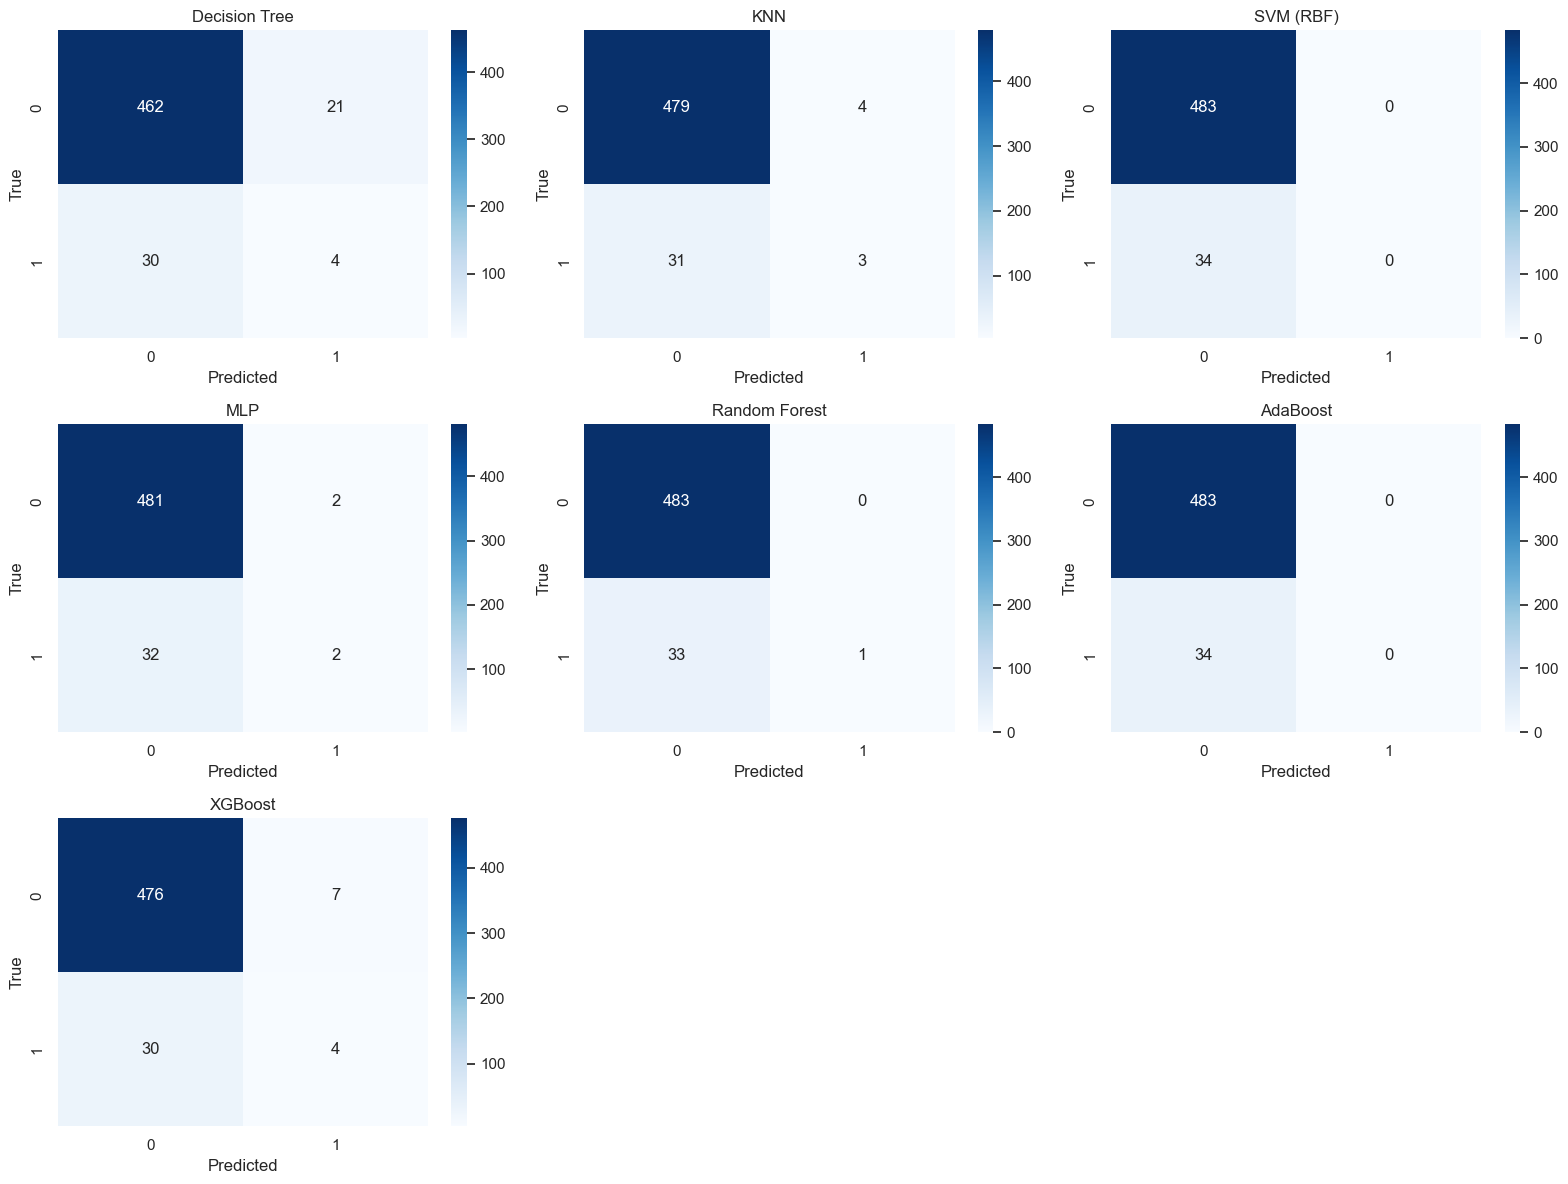

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

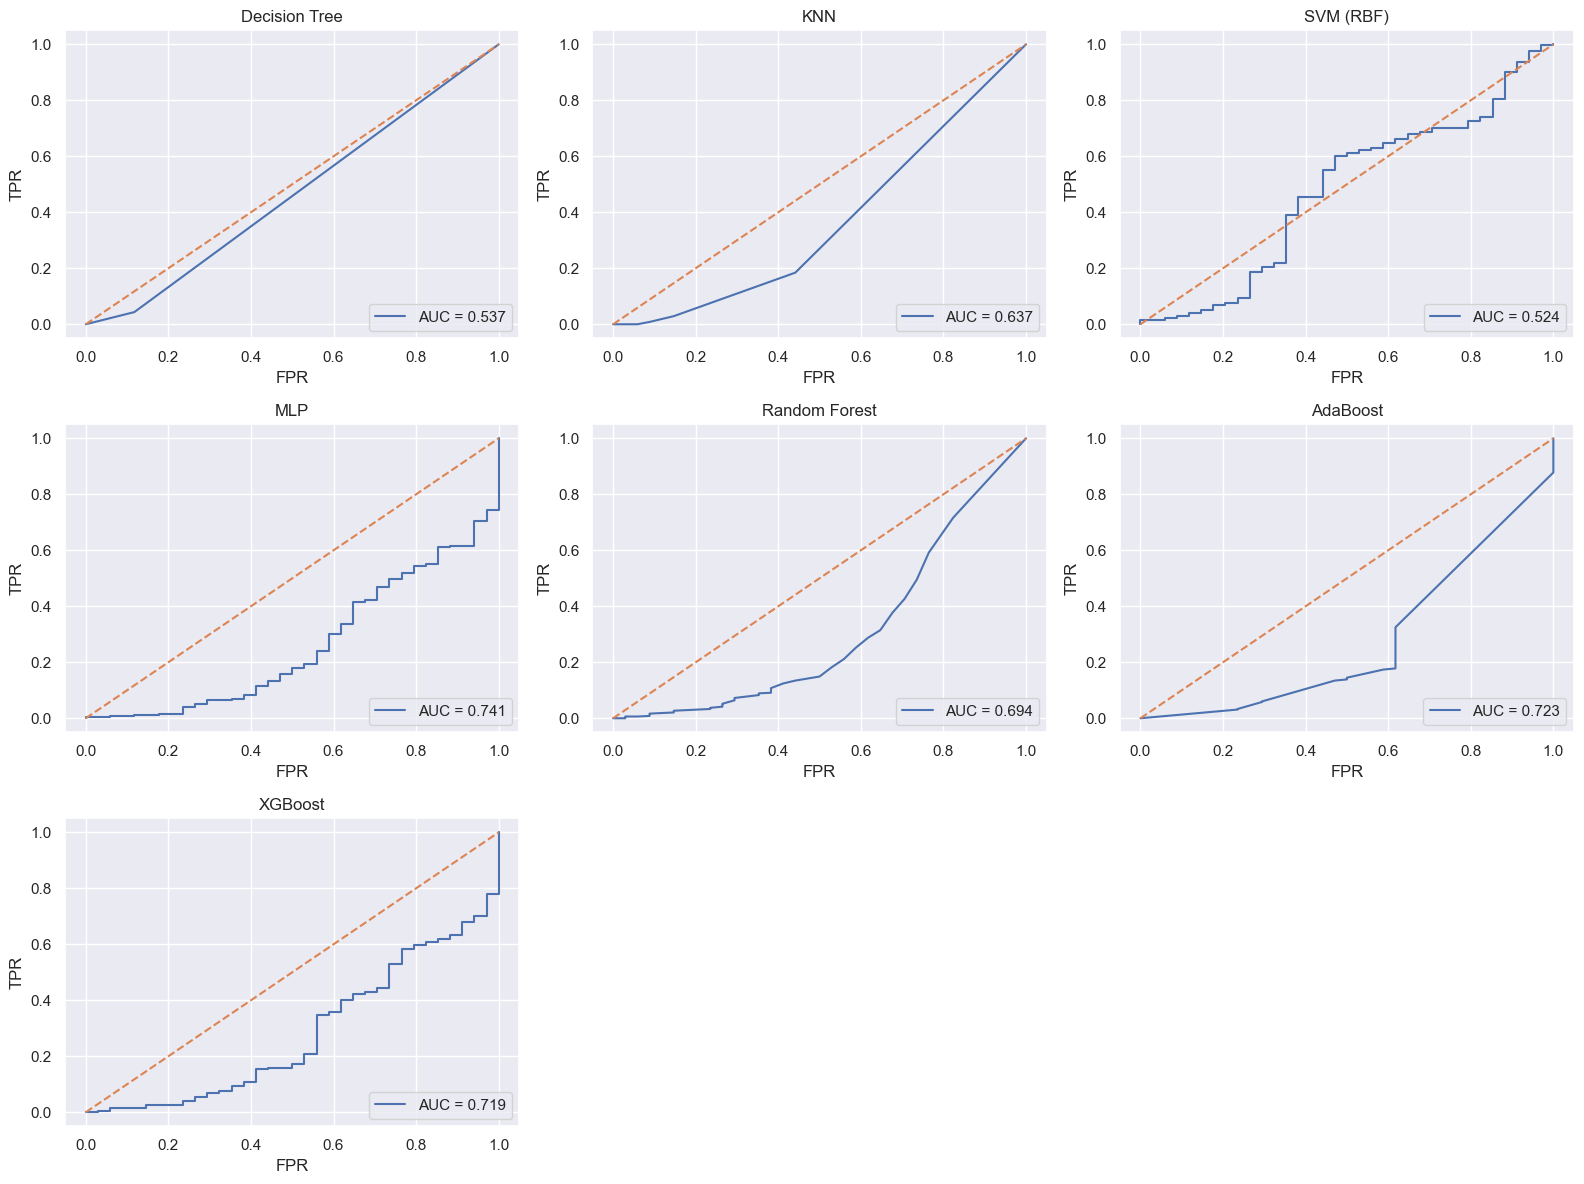

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

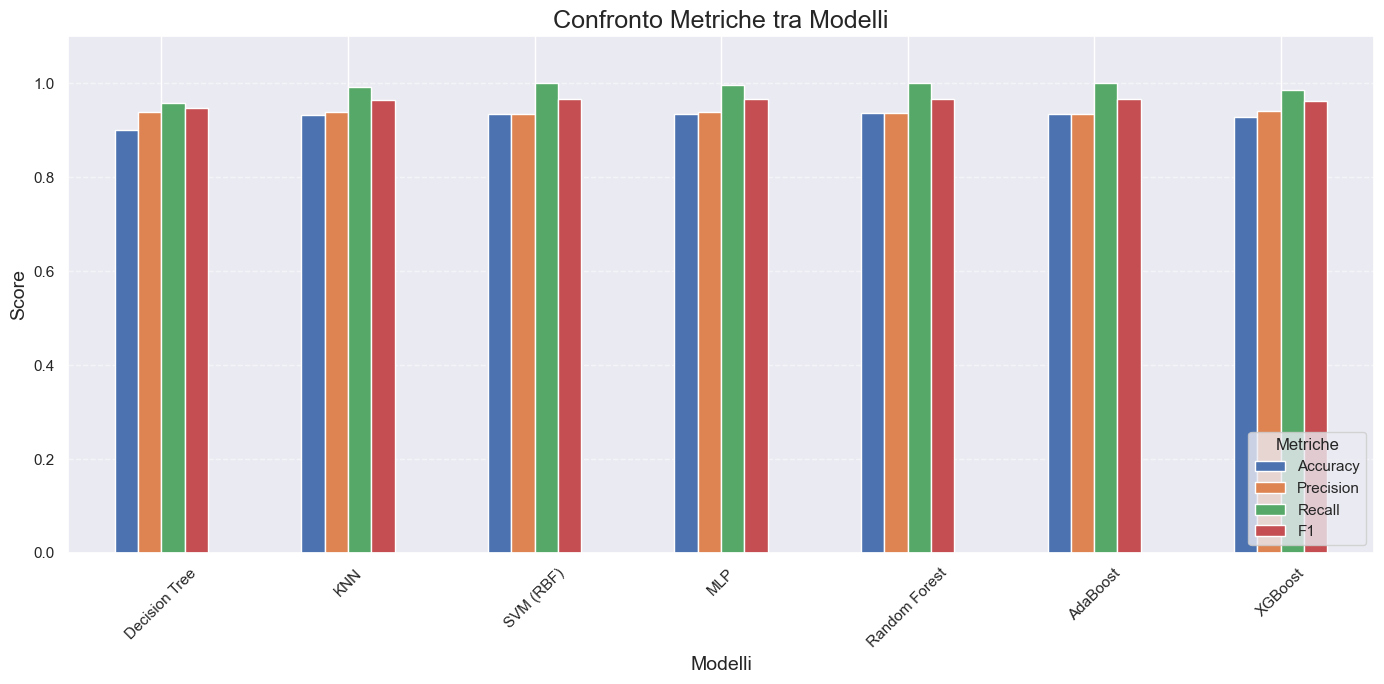

In [ ]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
def train_eval_2d_models(
    models,                      # dict: {"AdaBoost": AdaBoostClassifier(...), "SVM": SVC(...), ...}
    X_train_2d, X_test_2d,
    y_train, y_test,
    feature_names_2d,
    strat_cv,
    task_type='binary',
    pos_label=1,
    do_plot=True
):
    """
    Esegue:
    - CV f1 per ciascun modello
    - fit finale
    - evaluate_model sul test
    - opzionale: plot 2D (una volta sola, non per ogni modello)
    Ritorna un dict con metrics + cv_scores.
    """
    results = {}

    # plot 2D unico (opzionale)
    if do_plot:
        plt.figure(figsize=(8,6))
        plt.scatter(
            X_train_2d[:, 0], X_train_2d[:, 1],
            c=y_train, cmap="coolwarm", alpha=0.7, edgecolor="k"
        )
        plt.xlabel(feature_names_2d[0] + " (Scaled)")
        plt.ylabel(feature_names_2d[1] + " (Scaled)")
        plt.title(f"Distribuzione classi 2D\n({feature_names_2d[0]} & {feature_names_2d[1]})")
        plt.colorbar(label="Classe")
        plt.show()

    for name, est in models.items():
        print(f"\n=== Modello: {name} ===")
        model = clone(est)

        cv_scores = cross_val_score(model, X_train_2d, y_train, cv=strat_cv, scoring='f1')
        cv_mean = cv_scores.mean()
        cv_std  = cv_scores.std()

        print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

        model.fit(X_train_2d, y_train)
        metrics = evaluate_model(model, X_test_2d, y_test, task_type, pos_label, False)

        print("   >> Metriche test:", metrics)

        results[name] = {
            "cv_scores": cv_scores,
            "cv_mean": cv_mean,
            "cv_std": cv_std,
            "metrics": metrics
        }

    return results